# Variant of the Original Jeff Classifier

This notebook copies and build out Part III of `jeff_classifier.py` - that is, the section that trains and tests a classifier on the generated data.

## Setup

In [1]:
from itertools import chain
import html
import ujson as json
import multiprocessing as mp
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold

from helpers import all_scoring_metrics
from helpers import draw_rocs

%matplotlib inline
sns.set(font='monospace')

num_folds = 10
eval_columns = ['f1',
                'accuracy',
                'true_negative_rate',
                'true_positive_rate',
                'roc_auc',
                'roc_fpr',
                'roc_tpr',
                'roc_thresholds']
price_cols = ['duration_in_mins',
              'price',
              'price_per_min']

In [2]:
df = pd.read_pickle('../../data/merged/data_to_use_by_phone_v4.pkl')
print(df.shape)
print(df['class'].value_counts())

(567, 150)
False    508
True      59
Name: class, dtype: int64


In [3]:
id_cols = {'class', 'phone'}
price_cols = {x for x in df.columns if x.find('price') > -1}
duration_cols = {x for x in df.columns if x.find('duration') > -1}
flag_cols = {x for x in df.columns if x.find('flag_') > -1}
ethnicity_cols = {x for x in df.columns if x.find('ethnicity_') > -1}

In [4]:
etc = ExtraTreesClassifier(oob_score=True,
                           bootstrap=True,
                           random_state=2,
                           n_estimators=100,
                           n_jobs=-1,
                           class_weight="balanced")

rf = RandomForestClassifier(oob_score=True,
                            random_state=2,
                            n_estimators=100,
                            n_jobs=-1,
                            class_weight="balanced")

## Execution!

In [5]:
y_series = df['class']
X_df = df.loc[:, sorted(set(df.columns) - id_cols)]
print(y_series.shape)
print(X_df.shape)

(567,)
(567, 148)


### Extra Trees

In [6]:
etc_metrics = all_scoring_metrics(etc, X_df, y_series, StratifiedKFold(y_series, num_folds))

In [7]:
this_metrics = etc_metrics
print(this_metrics.roc_auc.mean())
this_metrics.loc[:, ['f1', 'accuracy', 'true_negative_rate', 'true_positive_rate', 'roc_auc']]

0.861111111111111


,f1,accuracy,true_negative_rate,true_positive_rate,roc_auc
0,0.250000,0.894737,0.980392,0.166667,0.823529
1,0.000000,0.824561,0.921569,0.000000,0.751634
2,0.000000,0.877193,0.980392,0.000000,0.630719
3,0.166667,0.824561,0.901961,0.166667,0.905229
4,0.153846,0.807018,0.882353,0.166667,0.841503
5,0.285714,0.912281,1.000000,0.166667,0.949346
6,0.444444,0.912281,0.980392,0.333333,0.818627
7,0.285714,0.912281,1.000000,0.166667,0.890523
8,1.000000,1.000000,1.000000,1.000000,1.000000
9,0.909091,0.981818,0.980000,1.000000,1.000000


missing_similar_images_count:max             0.042835
missing_exp_ads_from_simimages_count:max     0.033108
missing_similar_images_count:50%             0.031104
missing_exp_ads_from_simimages_count:50%     0.024144
missing_exp_ads_from_simimages_count:75%     0.022991
missing_exp_ads_from_simimages_count:mean    0.022114
missing_similar_images_count:mean            0.020084
missing_similar_images_count:std             0.018508
missing_exp_ads_from_simimages_count:std     0.017943
missing_similar_images_count:75%             0.017718
flag_Juvenile                                0.017661
n_incall                                     0.016182
n_ads                                        0.015910
age:min                                      0.014995
n_incall_and_outcall                         0.014335
images_count:min                             0.013553
n_distinct_locations                         0.013448
age:max                                      0.013415
images_count:max            

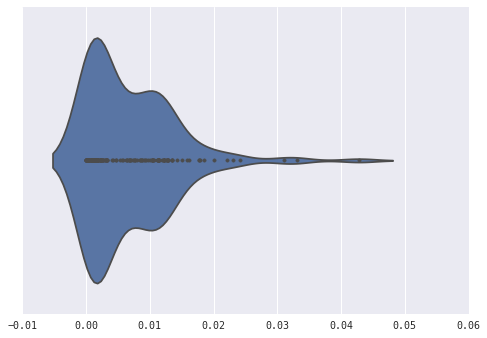

In [8]:
ranked_imptncs = this_metrics.loc[:,
                                  sorted(set(this_metrics.columns) - 
                                         set(eval_columns))].mean().sort_values(ascending=False)
print(ranked_imptncs.head(20))
sns.violinplot(ranked_imptncs, inner='point')

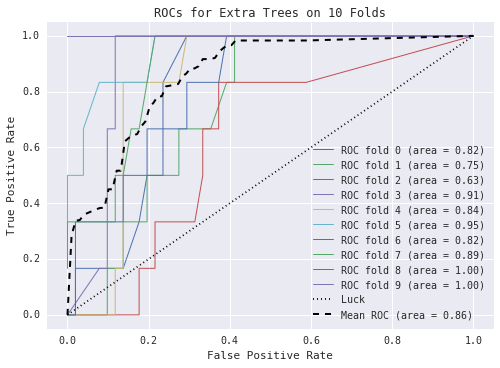

In [9]:
draw_rocs(this_metrics, 'Extra Trees')

### Random Forest

In [10]:
rf_metrics = all_scoring_metrics(rf, X_df, y_series, StratifiedKFold(y_series, num_folds))

In [11]:
this_metrics = rf_metrics
print(this_metrics.roc_auc.mean())
this_metrics.loc[:, ['f1', 'accuracy', 'true_negative_rate', 'true_positive_rate', 'roc_auc']]

0.856045751633987


,f1,accuracy,true_negative_rate,true_positive_rate,roc_auc
0,0.250000,0.894737,0.980392,0.166667,0.864379
1,0.000000,0.807018,0.901961,0.000000,0.733660
2,0.000000,0.877193,0.980392,0.000000,0.490196
3,0.285714,0.824561,0.882353,0.333333,0.895425
4,0.000000,0.771930,0.862745,0.000000,0.839869
5,0.500000,0.929825,1.000000,0.333333,0.952614
6,0.444444,0.912281,0.980392,0.333333,0.831699
7,0.666667,0.947368,1.000000,0.500000,0.952614
8,1.000000,1.000000,1.000000,1.000000,1.000000
9,1.000000,1.000000,1.000000,1.000000,1.000000


missing_exp_ads_from_simimages_count:mean     0.035429
missing_similar_images_count:mean             0.033245
age:min                                       0.033187
age:count                                     0.030219
age:mean                                      0.028290
exp_ads_from_simimages_count:50%              0.025456
missing_age:count                             0.020479
age:max                                       0.020102
missing_similar_images_count:count            0.019596
missing_exp_ads_from_simimages_count:count    0.019392
flag_Juvenile                                 0.019364
n_ads                                         0.018821
missing_exp_ads_from_simimages_count:std      0.018572
missing_similar_images_count:std              0.018024
similar_images_count:25%                      0.017886
missing_price:count                           0.017616
missing_duration_in_mins:count                0.017075
similar_images_count:50%                      0.016949
missing_pr

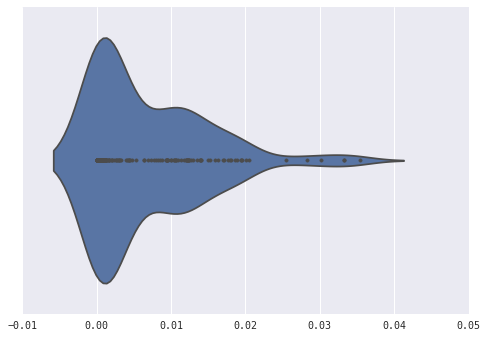

In [12]:
ranked_imptncs = this_metrics.loc[:,
                                  sorted(set(this_metrics.columns) - 
                                         set(eval_columns))].mean().sort_values(ascending=False)
print(ranked_imptncs.head(20))
sns.violinplot(ranked_imptncs, inner='point')

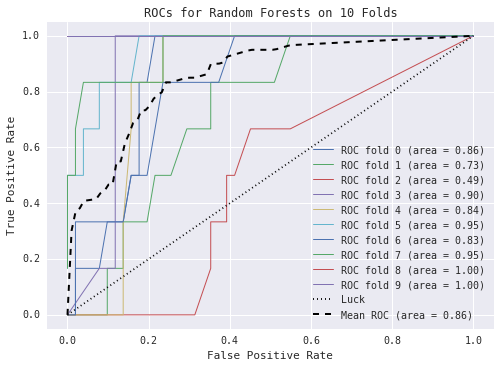

In [13]:
draw_rocs(this_metrics, 'Random Forests')